**Исследование объявлений о продаже квартир**   
В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Так как нам нужно выявить аномалии и тенденции рынка недвижимости, одной из основных задачей будет являтся исследования факторов влияющих на рыночную стоимость объекта недвижимости. Выявление таких факторов позволит построить автоматизированную систему: которая отследит аномалии и мошенническую деятельность.  

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

**Задачи проекта:**  

Предобработка данных с целью очистки таблиц от дубликатов, пропусков и аномальных значений;  
Анализ рынка недвижимости Санкт-Петербурга и соседних населенных пунктов;
Исследования факторов влияющих на конечную стоимость объекта недвижимости;
Подсчет стоимости за квадратный метр в 10 самых популярных населенных пунктов;
Расчет стоимости каждого километра от центра Санкт-Петербурга.

**Цель проекта:**  

Выявления интересных аномалий и тенденций рынка недвижимости Санкт-Петербруга и соседних населенных пунктов.  

Для удобства навигации по проекту снизу расположено его содержание.  

# Исследование объявлений о продаже квартир


### Откройте файл с данными и изучите общую информацию.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep = '\t')
pd.set_option('display.max_columns', None)

In [ ]:
display(data.head())
data.info()
data.hist(figsize=(10, 20))

Присутсвуют проблемы с данными.  Есть пропущенные значения, неверные форматы данных, выбивающиеся значения и дубликаты

### Предобработка данных

Заполнение пропусков на медианные

In [ ]:
ceiling_height_median = data['ceiling_height'].median()
data['ceiling_height'] = data['ceiling_height'].fillna(ceiling_height_median) # определение высота потолка

Предобработка данных по заполнению пропусков

In [ ]:
data['balcony'] = data['balcony'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['parks_nearest'] = data['parks_nearest'].fillna(0)
data['ponds_nearest'] = data['ponds_nearest'].fillna(0)
data['rooms'] = data['rooms'].fillna(0)
data['floors_total'] = data['floors_total'].fillna(1)
data['is_apartment'] = data['is_apartment'].fillna(False)
data['airports_nearest'] = data['airports_nearest'].fillna(0)
data['locality_name'] = data['locality_name'].fillna('пусто')

Заполнение пропусков нулями или значениями для дальнейших расчетов

Преобразование типов данных

In [ ]:
data['total_area'] = data['total_area'].astype('float64')
data['living_area'] = data['living_area'].astype('float64')
data['ceiling_height'] = data['ceiling_height'].astype('float64')
data['cityCenters_nearest'] = data['cityCenters_nearest'].astype('float64')
data['kitchen_area'] = data['kitchen_area'].astype('float64')
data['airports_nearest'] = data['airports_nearest'].astype('float64')
data['parks_nearest'] = data['parks_nearest'].astype('float64')
data['locality_name'] = data['locality_name'].astype('str')
data['rooms'] = pd.to_numeric(data['rooms'])
data['floor'] = pd.to_numeric(data['floor'])
data['balcony'] = data['balcony'].astype('int')
data['floors_total'] = pd.to_numeric(data['floors_total'])
data['days_exposition'] = pd.to_numeric(data['days_exposition'])
data['last_price'] = pd.to_numeric(data['last_price'])
data['floors_total'] = pd.to_numeric(data['floors_total'])
data['living_area'] = pd.to_numeric(data['living_area'])
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')

Перевод числовых показателей в integer или float. Временной показатель в стандартный вид даты

In [ ]:
living_area_non_null = data.query('living_area > 0')
koef = living_area_non_null['total_area']/living_area_non_null['living_area'].mean()
koef_mean = koef.mean()
data['living_area'] = data['living_area'].fillna(data['total_area']/koef_mean)

kitchen_area_non_null = data.query('kitchen_area > 0')
koef1 = kitchen_area_non_null['total_area']/kitchen_area_non_null['kitchen_area'].mean()
koef1_mean = koef1.mean()
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area']/koef1_mean)

Заполнение пустых значений в жилой площади и площади кухни по коэффициентам

In [ ]:
renames = ['поселок','поселок городского типа','посёлок городского типа','поселок Рябово','поселок городского типа Рябово']
to_renames = ['посёлок','городской посёлок','городской посёлок', 'посёлок городского типа Рябово', 'посёлок городского типа Рябово']
data['locality_name'] = data['locality_name'].replace(renames,to_renames)

data.duplicated().sum()
data = data.drop_duplicates()

<AxesSubplot:>

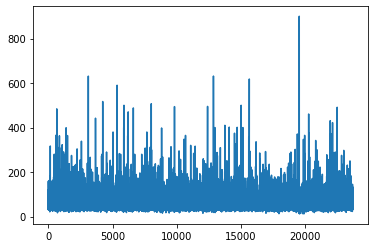

In [ ]:
#print(data['total_area'].unique())
data['total_area'].plot()

Замена названий населенных пунктов и удаление дупликатов

In [ ]:
#data['rooms'].hist(bins=30, range = (0, 20));

data = data.query('total_area < 200')
data = data.query('ceiling_height < 3.5')
data = data.query('last_price < 200000000')
data = data.query('rooms < 6')

Произвел вычисления для удаления аномальных значений

### Посчитайте и добавьте в таблицу новые столбцы

In [ ]:
# Новые столбцы

data['cost_per_meter'] = data['last_price']/data['total_area']
data['day_first_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).weekday
data['month_first_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['year_first_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).year
data['city_centr_km'] = data['cityCenters_nearest']/1000
data['city_centr_km'] = round(data['city_centr_km'], 0)

Добавление новых столбцов по заданию. Стоимость кв м, день недели, месяц  и год начала продажи, также количество км до центра города

In [ ]:
def floor_type(floor, floors_total):
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'

data['type_of_floor'] = data.apply(lambda x: floor_type(x.floor, x.floors_total), axis=1)


Добавление слобца с категорией этажа, последний первый итд.

Гистограмма по общей площади

<AxesSubplot:>

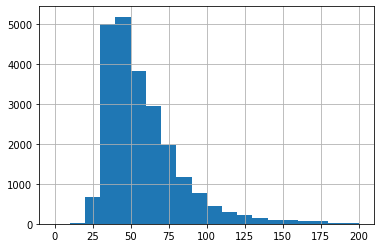

In [ ]:
data['total_area'].hist(bins = 20, range = (0, 200))

Больше всего квартир от 30 до 50 кв м

<AxesSubplot:>

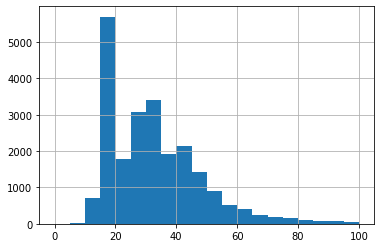

In [ ]:
# Гистограмма по жилой площади
data['living_area'].hist(bins = 20, range = (0, 100))

Маленьких квартир больше всего

<AxesSubplot:>

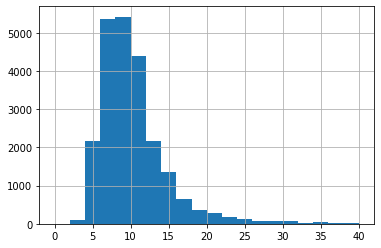

In [ ]:
# Гистограмма по площади кухни
data['kitchen_area'].hist(bins = 20, range = (0, 40))

Маленьких квартир больше всего, а у них маленькие кухни

<AxesSubplot:>

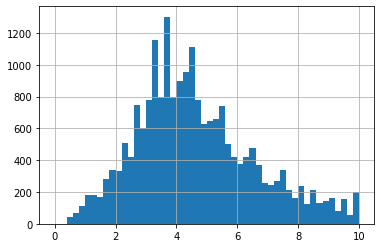

In [ ]:
# Гистограмма по цене
(data['last_price']/1000000).hist(bins = 50, range = (0, 10))

Цены сильно разняться, но в целом средняя цена около 4 млн рублей

<AxesSubplot:>

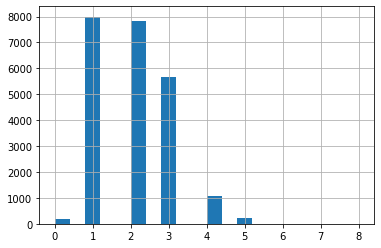

In [ ]:
# Гистограмма по количеству комнат
data['rooms'].hist(bins = 20, range = (0,8))

Однушки и двушки популярны

<AxesSubplot:>

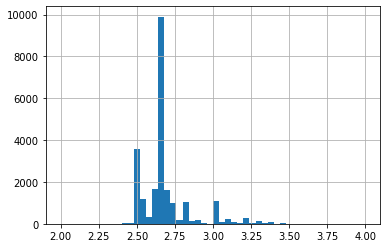

In [ ]:
# Гистограмма по высоте потолка
data['ceiling_height'].hist(bins = 50, range = (2, 4))

У большинства потолок примерно 2.5-2.75 м

<AxesSubplot:>

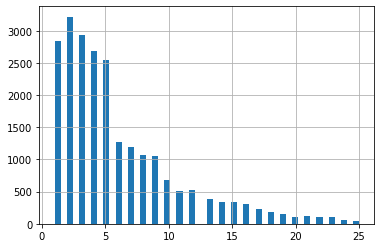

In [ ]:
# Гистограмма по этажам
data['floor'].hist(bins = 50, range = (1, 25))

До 5 этажа самые популярные

<AxesSubplot:>

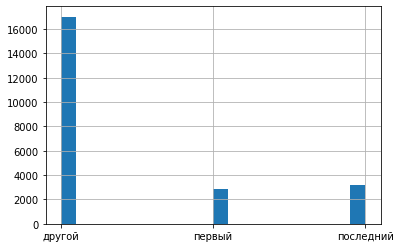

In [ ]:
# Гистограмма по типам этажа
data['type_of_floor'].hist(bins = 20)

Меньше всего квартир на последнем этаже, после на первом и все остальные на иных этажах

<AxesSubplot:>

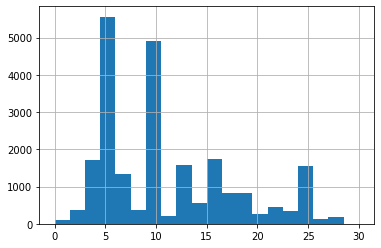

In [ ]:
# Гистограмма по количеству этажей
data['floors_total'].hist(bins = 20, range = (0, 30))

Пятиэтажки и десяти этажные домов больше всего

<AxesSubplot:>

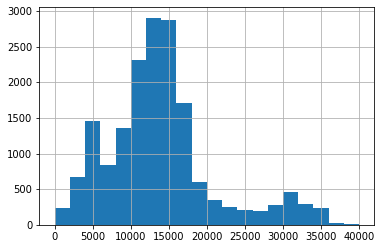

In [ ]:
# Гистограмма по расстоянию до центра
data['cityCenters_nearest'].hist(bins = 20, range = (0, 40000))

Чаще всего около 15 км до центра. Районы у окраин города

<AxesSubplot:>

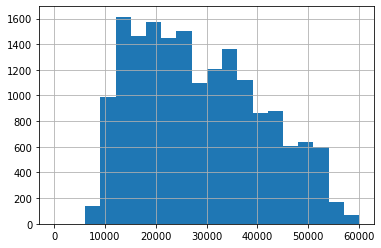

In [ ]:
# Гистограмма по расстоянию до аэропорта
data['airports_nearest'].hist(bins = 20, range = (100,60000))

Люди живут минимум в 10 км в аэропорта. В среднем около 25-30 км

<AxesSubplot:>

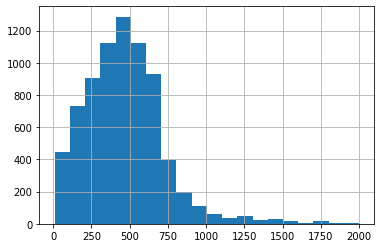

In [ ]:
# Гистограмма по расстоянию парков до квартиры
data['parks_nearest'].hist(bins = 20, range = (10,2000))

Большинству идти до парка до 750 метров.

<AxesSubplot:>

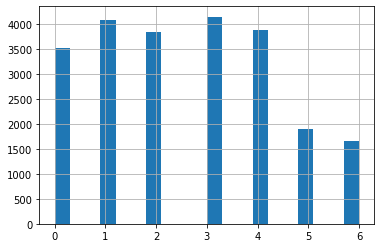

In [ ]:
# Гистограмма по дням неделям начала продаж
data['day_first_exposition'].hist(bins = 20)

В выходные люди менее активны в выставлении квартир на продажу

<AxesSubplot:>

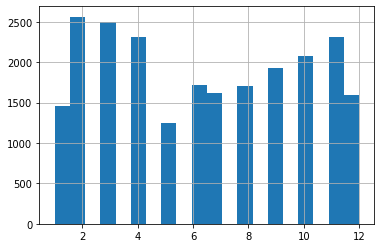

In [ ]:
# Гистограмма по дням месяцам начала продаж
data['month_first_exposition'].hist(bins = 20)

Зимой пик активности продаж квартир. К лету наблюдается спад

### Проведите исследовательский анализ данных

Задание: "Изучите, как быстро продавались квартиры (столбец days_exposition).

178.6545536339098
94.0


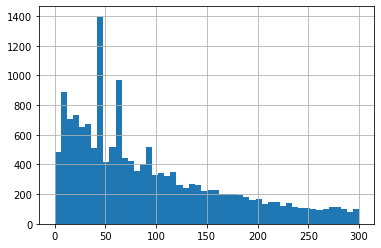

In [ ]:
data_exposition = data['days_exposition']
data_exposition.hist(bins = 50, range = (0, 300))

data_exposition_mean = data_exposition.mean() # 178 дней
print(data_exposition_mean)
data_exposition_median = data_exposition.median() # 94 дней
print(data_exposition_median)

#print(data['days_exposition'].describe())

В среднем квартиры продаются около 94 дней. Медианное значение около 178 дней. До 94 укладываются половина продаж.
В целом это довольно таки быстро. Продажи более 178 дней уже продолжительные  
Возможно сделки по продаже кватир в среднем столько длятся. Тяжело что-то сказать. Может это аномалии, но их количество большое

Задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта?

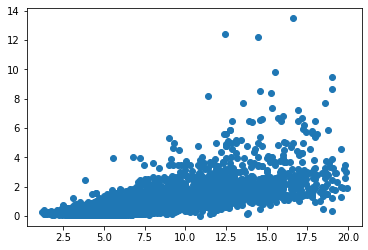

In [ ]:
# График по количеству кв м
plt.scatter(data['total_area']/10, data['last_price']/10000000)
plt.show()

Чем больше площадь тем больше цена. Но также куда важнее другие факторы, которые влияют на цену квартиры, пложадь играем не первостепнное значение. Думаю местоположение играет куда более важную роль в ценообразовании

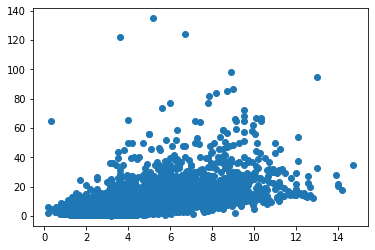

In [ ]:
# График по жилой площади
plt.scatter(data['living_area']/10, data['last_price']/1000000)
plt.show()

Такой же вывод что с общей площадью квартиры. Площадь жилой зоны играет роль в стоимости квартиры, но есть иные факторы, которые куда больше определяют стоимость

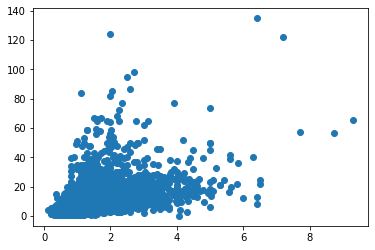

In [ ]:
# График по площади кухни
plt.scatter(data['kitchen_area']/10, data['last_price']/1000000)
plt.show()

Такой же вывод что с общей площадью квартиры. Площадь кухни играет роль в стоимости квартиры, но есть иные факторы, которые куда больше определяют стоимость

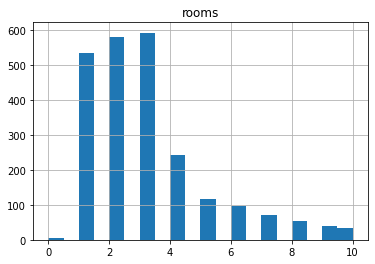

In [ ]:
# График по количеству комнат
pivot_rooms = (data.pivot_table(index = 'last_price', values = 'rooms', aggfunc = 'sum')
                    .hist(bins = 20 , range = (0, 10)))

Люди предпочатают стандартные варианты квартир: одно, двух и трех комнатные квартиры. Дороже всего продают двух и трех комнатные квартиры

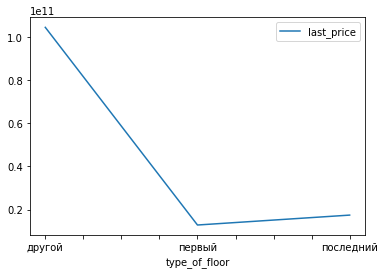

In [ ]:
# График по типу этажа
pivot_type_of_floor = (data.pivot_table(index = 'type_of_floor', values = 'last_price', aggfunc = 'sum')
                    .plot())

Меньше всего квартир на последнем этаже, после на первом и все остальные на иных этажах

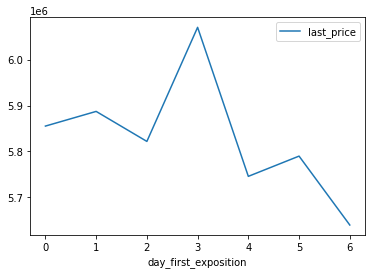

In [ ]:
# График по дню недели начала продажи
pivot_day_first_exposition = (data.pivot_table(index = 'day_first_exposition', values = 'last_price')
                    .plot())

Самый активный день это четверг

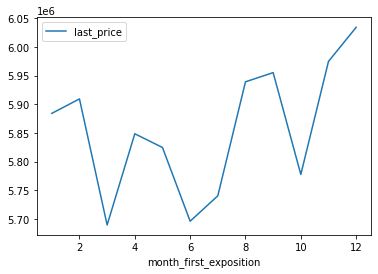

In [ ]:
# График по месяцу начала продажи
pivot_month_first_exposition = (data.pivot_table(index = 'month_first_exposition', values = 'last_price')
                    .plot())

Зимой много кто продает квартиры. Август и сентябрь выделятся своей активностью. Также прирост приходится на апрель

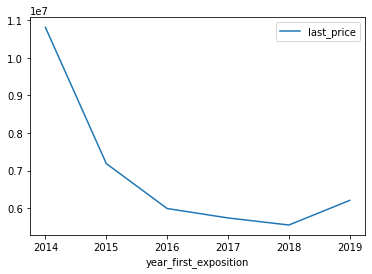

In [ ]:
# График по году начала продажи
pivot_year_first_exposition = (data.pivot_table(index = 'year_first_exposition', values = 'last_price')
                    .plot())

Все идет на спад с 2014 года, последствия кризиса. Более менее начали восстанавливаться продажи в 2019 году

Задание "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [ ]:
data['cost_per_meter'] = data['cost_per_meter'].astype('int')
locality_name_count = data.value_counts('locality_name')
print(locality_name_count.head(10))

data_top1 = data[data['locality_name'] == "Санкт-Петербург"]
print('Средняя цена кв м в Питере, как населенном пункте с наибольшим количеством квартир:', round(data_top1['cost_per_meter'].mean()))
data_top10 = data[data['locality_name'] == "Выборг"]
print('Средняя цена кв м в ВЫборге, как населенном пункте топ-10 по количеству квартир:', round(data_top10['cost_per_meter'].mean()))

locality_name
Санкт-Петербург      15111
посёлок Мурино         520
посёлок Шушары         439
Всеволожск             395
Пушкин                 355
Колпино                337
посёлок Парголово      326
Гатчина                305
деревня Кудрово        299
Выборг                 229
dtype: int64
Средняя цена кв м в Питере, как населенном пункте с наибольшим количеством квартир: 112706
Средняя цена кв м в ВЫборге, как населенном пункте топ-10 по количеству квартир: 57875


Большой город и большое количество квартир. Дальше идут лидеры по Лен области
В Санкт-Петербурге больше всего объявлений, топ-10 это Выборг

Задание: Расчет влияния расстояние квартиры до центра города

/tmp/ipykernel_805/346658927.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_per_km['Category'] = price_per_km['cityCenters_nearest'].apply(kilometr_cost)


,cost_per_meter
Category,
K1,168517.118644
K7,149662.206349
K6,144111.766716
K2,141448.228070
K8,138762.012755
K5,137115.850515
K3,134675.744493
K4,122275.625282
K9,119755.345400


<AxesSubplot:xlabel='cityCenters_nearest'>

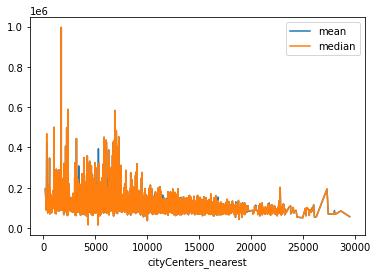

In [ ]:
price_per_km = data[data['locality_name'] == "Санкт-Петербург"]

def kilometr_cost(cityCenters_nearest):
    if cityCenters_nearest <= 1000:
        return 'K1'
    elif cityCenters_nearest > 1000 and cityCenters_nearest <= 2000:
        return 'K2'
    elif cityCenters_nearest > 2000 and cityCenters_nearest <= 3000:
        return 'K3'
    elif cityCenters_nearest > 3000 and cityCenters_nearest <= 4000:
        return 'K4'
    elif cityCenters_nearest > 4000 and cityCenters_nearest <= 5000:
        return 'K5'
    elif cityCenters_nearest > 5000 and cityCenters_nearest <= 6000:
        return 'K6'
    elif cityCenters_nearest > 6000 and cityCenters_nearest <= 7000:
        return 'K7'
    elif cityCenters_nearest > 7000 and cityCenters_nearest <= 8000:
        return 'K8'
    elif cityCenters_nearest > 8000 and cityCenters_nearest <= 9000:
        return 'K9'
    elif cityCenters_nearest > 9000 and cityCenters_nearest <= 10000:
        return 'K10'
    elif cityCenters_nearest > 10000 and cityCenters_nearest <= 11000:
        return 'K11'
    elif cityCenters_nearest > 11000 and cityCenters_nearest <= 12000:
        return 'K12'
    elif cityCenters_nearest > 12000 and cityCenters_nearest <= 13000:
        return 'K13'
    elif cityCenters_nearest > 13000 and cityCenters_nearest <= 14000:
        return 'K14'
    else:
        return 'K15'

price_per_km['Category'] = price_per_km['cityCenters_nearest'].apply(kilometr_cost)

price_per_km_grouped = price_per_km.pivot_table(index = 'Category', values = 'cost_per_meter', aggfunc ='mean')
display(price_per_km_grouped.sort_values(by = 'cost_per_meter', ascending = False))

# Способ номер 2
pivot_for_task = price_per_km.pivot_table(index = 'cityCenters_nearest', values = 'cost_per_meter', aggfunc = ('mean','median'))
pivot_for_task.plot()

Что и требовалось доказать, чем ближе к центру квартира тем выше цена за 1 кв м

### Общий вывод

Были обработаны данные по продажам квартир в Ленинградской области с 2014 по 2019 года.

Провелась работа по замещены пустоты медианными значениями по необходимости, обработами пустоты, дубликаты и устранению аномальных значений.

Исследование показало, что большее количество квартир продавалось в Санкт-Петербурге (15182 объявлений), ведь это второй город в стране. Дальше идут поселок Мурино (520 квартир) и Шушары (439 квартир), как населенные пункты наиболее приближенные к городу. Там развивается активная застройка. Также не отстают города с историческим наследием. Такие как Пушкин (355 квартир), Гатчина (305 квартир) и Выборг (229 квартир). Туристы привлекают историей и местными достопримечательностями.

Общие наблюдения:

С 2014 года наблидается спад в продаже квартиры из-за кризиса 2014 года. В 2019 году пошел небольшой рост.
Выявлена прямая зависимость стоимости квадратного метра от близости к центру. Площадь недвижимости это не ключевой фактор в ценообразовании.
Крайне мало квартир на первом этаже, также как и на последнем. Обычно первый этаж отдают в аренду для различных бизнесов. Последний этаж привлекателен видом.
Зима наиболее активное время для продажи квартир, видимо люди устают от климата в Питере. Пик публикаций объявлений по дням недели замечен в четверг.
Наиболее популярными видами квартир являются однокомнатные и двухкомнатые квартиры. Далее следуют трехкомнатные квартиры.
Большинство квартир имют высоту потолка примерно 2.5-2.75 м.
Достаточно много парков в Ленинградской области. Большая часть квартир располагается в 750 метрах до ближайшего парка
В среднем до аэропорта добираться около 20 км.
В среднем квартира продается 94 дня. Быстрые продажи присутсвуют до 94 дней и долгие от 178 дней